Background

The bandwidth and frequency covered by 6G wireless communication are unprecedented. According to the 6G white paper, at least the 300GHz~10THz band needs to be covered to meet the proposed key technical indicators (100Gbit/s~1Tbit/s peak transmission speed and 0.1ms level communication delay). In addition, the 6G wireless communication system will be a complex and ultra-dense heterogeneous network system in which multiple services coexist and numerous communication technologies are integrated [1]. In this scenario, an intelligent spectrum management system is required to manage spectrum resources, optimize network performance, and resolve the contradiction between supply and demand scientifically and efficiently. The research on cognitive-based intelligent spectrum management systems is imperative.






Overview

We announce a deep learning-based challenge to address an automatic modulation recognition task. Several datasets are composed of sub-Nyquist-rate time-domain samples on GHz bandwidth baseband signals [2,3]. Both training sets and testing sets are provided with labels indicating modulation of the signal. The task is to recognize the signal locations in the frequency domain indicated by pre-defined discrete channel indexes and the modulation types of the signals located somewhere in the baseband. Participants are required to train their models using the training set and verify their model with the verification set for the best possible performance. The submitted models will be evaluated on an unpublished test dataset. The competition will contain one basic challenge and one advanced challenge.

In [1]:

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import h5py
import time
import datetime
import random as python_random
import json
import gc
import pickle


from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Introduction
In this section will define constant and load data from file

In [2]:
RANDOM_SEED = 100

# 16 orders 8 pairs of I/Q signals
ORDER = ["I1", "Q1", "I2", "Q2", "I3", "Q3", "I4", "Q4",
         "I5", "Q5", "I6", "Q6", "I7", "Q7", "I8", "Q8"]
# Module labels
MOD = ["APSK16", "APSK32", "APSK64", "ASK8", "BPSK", "OQPSK",
       "PSK16", "PSK8", "QAM128", "QAM16", "QAM256", "QAM64", "QPSK"]


In [3]:
# Configuration for Colab, make sure you have dataset store in a correct folder
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# DATASET_PATH = 'drive/MyDrive/TFM'
# TRAIN_FILEPATH=DATASET_PATH+'/data_1_train.h5'
# TEST_FILEPATH=DATASET_PATH+'/data_1_test.h5'


In [4]:
# Configuration for local machine
DATASET_PATH = 'dataset'
TRAIN_FILEPATH = DATASET_PATH+'/data_1_train.h5'
TEST_FILEPATH = DATASET_PATH+'/data_1_test.h5'

In [5]:
def load_data(filepath):
    """function that load datasett

    Args:
        file_name (string): path of dataset

    Returns:
        np.array: array of 
    """
    print("Load data from {}".format(filepath))
    with h5py.File(filepath, 'r') as f:
        print(f.keys())
        print("X shape:", f['X'].shape)
        print("Y shape:", f['Y'].shape)
        return np.array(f['X']), np.array(f['Y'])


In [6]:
X_data, Y_data = load_data(TRAIN_FILEPATH)
X_test_data, Y_test_data = load_data(TEST_FILEPATH)
print("Classes:", np.unique(Y_data))
print("Labels:", MOD)


Load data from dataset/data_1_train.h5
<KeysViewHDF5 ['X', 'Y']>
X shape: (124800, 1024, 16)
Y shape: (124800, 1)
Load data from dataset/data_1_test.h5
<KeysViewHDF5 ['X', 'Y']>
X shape: (31200, 1024, 16)
Y shape: (31200, 1)
Classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Labels: ['APSK16', 'APSK32', 'APSK64', 'ASK8', 'BPSK', 'OQPSK', 'PSK16', 'PSK8', 'QAM128', 'QAM16', 'QAM256', 'QAM64', 'QPSK']


# Data analysis 
En esta parte se visualiza un ejemplo de cada clase, estadística de los datos y normalización de los datos

In [7]:
# Check nan value
if(np.isnan(X_data).any()):
    print("The dataset contains NaN values")
else:
    print("The dataset doesn't contains NaN values")


The dataset doesn't contains NaN values


## Data visualization

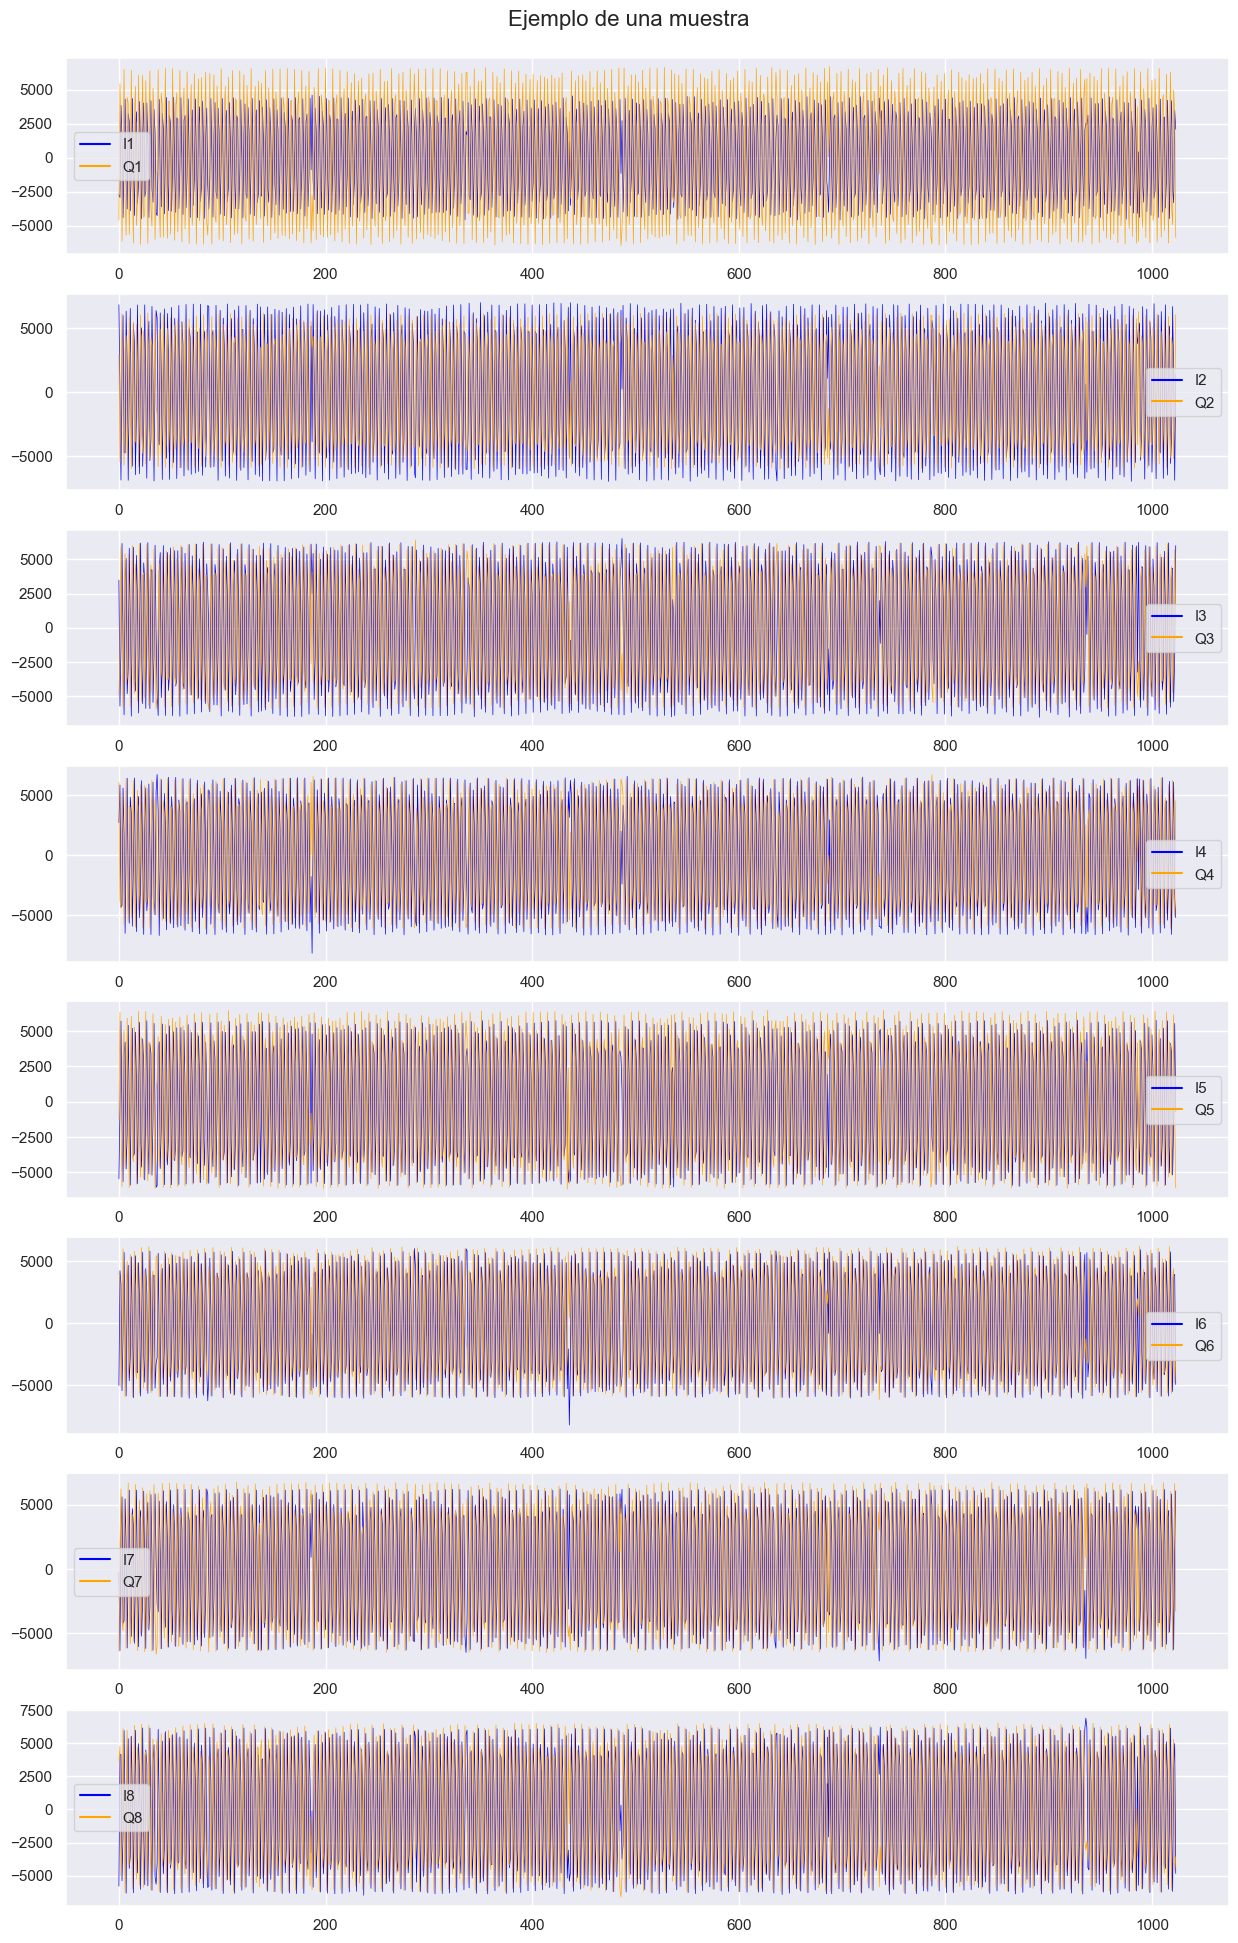

In [8]:
def plot_data(x, order_label=ORDER):
    """visualization of 1 sample

    Args:
        x (np.array): one sample
        order_label (_type_, optional): orders of signals. Defaults to ORDER.
    """
    x = np.transpose(x,[1,0])
    order = x.shape[0]
    sns.set_theme()
    fig, axes = plt.subplots(int(order/2), 1,  figsize=(15, int(3*order/2)))
    fig.suptitle("Ejemplo de una muestra", size=16, y=0.90)

    for idx in range(int(order/2)):
        Iidx = idx*2
        Qidx = idx*2+1
        
        
        i = pd.DataFrame(data={
            order_label[Iidx]: x[Iidx]
        })

        q = pd.DataFrame(data={
            order_label[Qidx]: x[Qidx]
        })
        sns.lineplot(data=i, linewidth=0.5, palette=['blue'], ax=axes[idx])
        sns.lineplot(data=q, linewidth=0.5, palette=['orange'], ax=axes[idx])
    plt.show()

plot_data(X_data[0])


## Statistics by order and modulation

In [9]:
def get_by_IQ(x, orden=ORDER):
    """Get summary group by order

    Args:
        x (np.array): dataset with  16,1024 format
        orden (list, optional): orders of signals. Defaults to ORDER.

    Returns:
        Dataframe: statistic of each order
    """
    data = {}
    gc.collect()
    for i in range(len(orden)):
        order_name = orden[i]
        data[order_name] = np.transpose(x, [0, 2, 1])[:, i].flatten()
    df = pd.DataFrame(data=data)
    return df


dfIQ = get_by_IQ(X_data)
print(dfIQ.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
del dfIQ
gc.collect()

                 I1            Q1            I2            Q2            I3  \
count  127795200.00  127795200.00  127795200.00  127795200.00  127795200.00   
mean          28.82        -18.91         26.02         17.11         12.47   
std         2796.78       3530.36       3482.73       3468.95       3520.36   
min        -9348.00      -7957.00      -8192.00      -8083.00      -8192.00   
25%        -2031.00      -2628.00      -2380.00      -2569.00      -2542.00   
50%           27.00        -18.00         13.00         16.00          6.00   
75%         2106.00       2559.00       2434.00       2572.00       2585.00   
max         7461.00       8191.00       8191.00       8191.00       8191.00   

                 Q3            I4            Q4            I5            Q5  \
count  127795200.00  127795200.00  127795200.00  127795200.00  127795200.00   
mean          28.05          7.91         12.67         -8.85         15.24   
std         3494.36       3604.16       3592.25    

26903

In [10]:
def get_by_mod(x, y, modulation=MOD):
    """Get summary group by order

    Args:
        x (np.array): dataset with 16,1024 format
        orden (list, optional): modulation labels of dataset. Defaults to MOD.

    Returns:
        Dataframe: statistic of each modulation
    """
    data = {}
    gc.collect()
    for idx in range(len(modulation)):
        label = idx+1
        data[modulation[idx]] = np.transpose(
            x, [0, 2, 1])[np.where(y == label)].flatten()
    df = pd.DataFrame(data=data)
    return df


dfmod = get_by_mod(X_data, Y_data, modulation=MOD)
print(dfmod.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
dfmod =None
gc.collect()


           APSK16      APSK32      APSK64        ASK8        BPSK       OQPSK  \
count  9830400.00  9830400.00  9830400.00  9830400.00  9830400.00  9830400.00   
mean        28.47       29.37       28.15       28.42       28.59       28.97   
std       2926.68     2764.42     2773.52     2257.20     3091.84     3200.73   
min      -8631.00    -8526.00    -8517.00    -8052.00    -8532.00    -8475.00   
25%      -2169.00    -2007.00    -2028.00    -1158.00    -2265.00    -2907.00   
50%         30.00       30.00       27.00       30.00       36.00       21.00   
75%       2247.00     2082.00     2100.00     1227.00     2355.00     2970.00   
max       7152.00     6927.00     7425.00     6807.00     7461.00     7425.00   

            PSK16        PSK8      QAM128       QAM16      QAM256       QAM64  \
count  9830400.00  9830400.00  9830400.00  9830400.00  9830400.00  9830400.00   
mean        28.86       29.08       28.85       29.59       29.12       28.84   
std       3151.87     3152.

0

# Model creation
In this section, different models based on neural networks are created using reduced dataset

In [2]:
# Use gpu when it's availaible
USE_GPU = True

# Percentage of data used for train and test, value are between 0-1, if the value is >= 1 then use full dataset
DATA_PROPORTION = 0.6
# use session id will continue executing previews
SESSION_ID = "20221215090103"

EXECUTION_FOLDER = SESSION_ID if SESSION_ID != "" else '{}'.format(
    datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
# The folder where the model is stored
MODEL_FOLDER = EXECUTION_FOLDER+'/model'


In [183]:
model_names = [name for name in os.listdir(MODEL_FOLDER)]

file_path = {}


def get_train_result_path(root=MODEL_FOLDER):
    model_names = [name for name in os.listdir(root)]
    file_path = {}
    for name in model_names:
        model_folder = f'{MODEL_FOLDER}/{name}'
        file_path[name] = {}
        list_dir = list(os.scandir(model_folder))
        for path in list_dir:
            p = path.path.replace('\\', '/')
            if path.is_file():
                if path.name.startswith('best'):
                    file_path[name]['best_model'] = p
                elif path.name.startswith('emissions'):
                    file_path[name]['emissions'] = p
                elif path.name.startswith('history'):
                    file_path[name]['history'] = p
                elif path.name.startswith('report'):
                    file_path[name]['report'] = p
        if len(file_path[name])!=4:
            file_path.pop(name, None)
    return file_path


result_path = get_train_result_path()
print(result_path)


{'cov5': {'best_model': '20221215090103/model/cov5/best_cov5.h5', 'emissions': '20221215090103/model/cov5/emissions.csv', 'history': '20221215090103/model/cov5/history.pkl', 'report': '20221215090103/model/cov5/report.json'}, 'cov5cnldnn': {'best_model': '20221215090103/model/cov5cnldnn/best_cov5cnldnn.h5', 'emissions': '20221215090103/model/cov5cnldnn/emissions.csv', 'history': '20221215090103/model/cov5cnldnn/history.pkl', 'report': '20221215090103/model/cov5cnldnn/report.json'}, 'cv3ldnn': {'best_model': '20221215090103/model/cv3ldnn/best_cv3ldnn.h5', 'emissions': '20221215090103/model/cv3ldnn/emissions.csv', 'history': '20221215090103/model/cv3ldnn/history.pkl', 'report': '20221215090103/model/cv3ldnn/report.json'}, 'stacked_cldnn': {'best_model': '20221215090103/model/stacked_cldnn/best_stacked_cldnn.h5', 'emissions': '20221215090103/model/stacked_cldnn/emissions.csv', 'history': '20221215090103/model/stacked_cldnn/history.pkl', 'report': '20221215090103/model/stacked_cldnn/report

In [184]:
def get_result_df(result_path):
    names = []
    times = []
    emissions = []
    for name, paths in result_path.items():
        with open(paths['report']) as f:
            report = json.load(f)
            names.append(name)
            times.append(report['train_time'])
        emi = pd.read_csv(paths['emissions'])
        emissions.append(emi["emissions"][0])
    return pd.DataFrame({
        "model name": names,
        "traning time": times,
        "emissions": emissions
    })


df = get_result_df(result_path)
df


,model name,traning time,emissions
0,cov5,4120.723012,0.133551
1,cov5cnldnn,6597.570636,0.184977
2,cv3ldnn,9290.576921,0.213985
3,stacked_cldnn,14244.569085,0.332589


[Text(0.5, 1.0, 'Training time in second')]

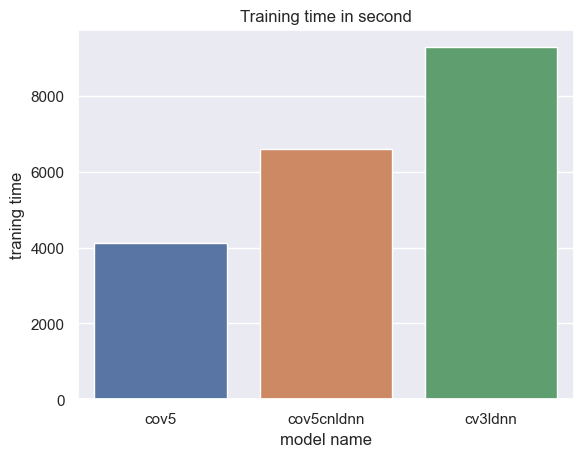

In [174]:
sns.set_theme()
sns.barplot(data=df, x="model name", y="traning time",).set(title='Training time in second')


[Text(0.5, 1.0, 'Emissions as CO2 in kg')]

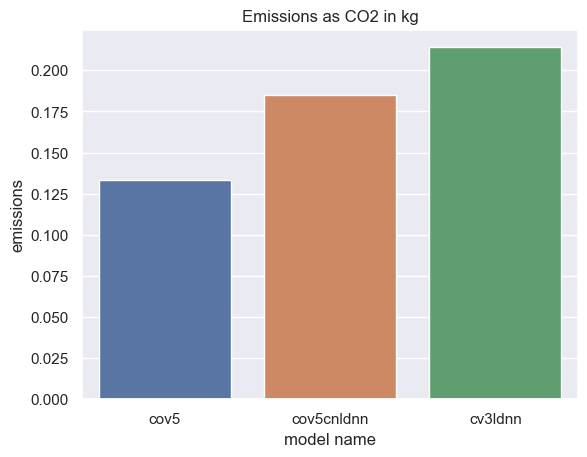

In [176]:
sns.barplot(data=df, x="model name", y="emissions").set(
    title='Emissions as CO2 in kg')


In [ ]:
#emissions
#accuracy with test dataset
#tranin time
#

In [12]:

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(RANDOM_SEED)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(RANDOM_SEED)

# Moreover, when running on a GPU, some operations have non-deterministic outputs, in particular tf.reduce_sum().
# This is due to the fact that GPUs run many operations in parallel, so the order of execution is not always guaranteed.
# Due to the limited precision of floats, even adding several numbers together may give slightly different results depending on the order in which you add them.


## Function for data transformation

In [13]:


def normalize_data(data):
    """ stand normalization along axis 0
    """
    data = data.astype('float64')
    mean = data[:, :, :].mean(axis=0)
    data[:, :, :] -= mean
    std = data[:, :, :].std(axis=0)
    data[:, :, :] /= std
    return data


def onehot(y):
    """onehot encoding for y 
    """
    return keras.utils.to_categorical(y-1)


def transform_dataset(X, Y):
    """transform X,Y into appropriate format for our models


    """
    return normalize_data(X), onehot(Y)


def get_split_transformed_data(X, Y, proportion, random_state=RANDOM_SEED):
    """return part of the data set according to the proportion

    Args:
        X : X of original dataset
        Y : Y of original dataset
        proportion (_type_): 0-1, percentage of data to return

    Returns:
        _type_: reduced data according to the proportion
    """
    if proportion >= 1 or proportion >= 1.0:
        return X, Y

    X_train, X_test, y_train, Y_test = train_test_split(
        X, Y, train_size=proportion, stratify=Y.flatten(), random_state=random_state)
    x_train_norm, y_train_onehot = transform_dataset(X_train, y_train)
    x_test_norm, y_test_onehot = transform_dataset(X_test, Y_test)
    return x_train_norm, y_train_onehot, x_test_norm, y_test_onehot


def get_n_split_transformed_data(x_data, y_data, n=3, random_state=RANDOM_SEED):
    """return Stratified split data set into N part
    """
    splits_idx = get_split_idx(y_data, n)
    split_data = []
    for i, split_idx in enumerate(splits_idx):
        x, y = x_data[split_idx], y_data[split_idx]
        x_train_norm, y_train_onehot = transform_dataset(x, y)
        split_data.append((x_train_norm, y_train_onehot))

    return split_data


def get_split_idx(y, n=2, random_state=RANDOM_SEED):
    """Stratified split dataset into n part

    """
    np.random.seed(random_state)
    classes = np.unique(y)
    classes_idx = []
    # generate random idx by class label

    for claz in classes:
        # get index of the class
        data_idx = np.where(y == claz)[0]
        # shuffle idx
        np.random.shuffle(data_idx)
        # split index into n part
        classes_idx.append(np.split(data_idx, n))
    # convert into np array
    idxs = np.array(classes_idx)
    # concat class of each split
    split_idx = np.concatenate(idxs, axis=1)
    # np.any(np.isin(split_idx[0], split_idx[1]))
    # np.all(np.isin(split_idx[0], split_idx[0]))
    return split_idx


## Create reduced data for traning

In [14]:
input_shape = X_data.shape[1:]
num_classes = len(np.unique(Y_data))
print("input shape:", input_shape)
print("num classes:", num_classes)

input shape: (1024, 16)
num classes: 13


In [15]:
x_train, y_train, x_valid, y_valid = get_split_transformed_data(
    X_data, Y_data, 0.6)
print("X train shape:", x_train.shape)
print("Y test shape:", y_train.shape)
print("X reduced shape:", x_train.shape)
print("Y reduced shape:", y_train.shape)
# free memory
X_data = None
Y_data = None
gc.collect()

#x_test_norm, y_test_onehot = transform_dataset(X_test_data, Y_test_data)
#
## free memory
#X_test_data = None
#Y_test_data = None
#gc.collect()


X train shape: (74880, 1024, 16)
Y test shape: (74880, 13)
X reduced shape: (74880, 1024, 16)
Y reduced shape: (74880, 13)


0

In [16]:
# show stat after normalization
dfnorm = get_by_IQ(x_train)
print(dfnorm.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
dfnorm =None
gc.collect()

                I1           Q1           I2           Q2           I3  \
count  76677120.00  76677120.00  76677120.00  76677120.00  76677120.00   
mean          0.00        -0.00        -0.00         0.00        -0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -3.34        -2.24        -2.37        -2.34        -2.34   
25%          -0.74        -0.74        -0.69        -0.75        -0.73   
50%          -0.00         0.00        -0.00        -0.00        -0.00   
75%           0.74         0.73         0.69         0.74         0.73   
max           2.65         2.34         2.36         2.37         2.33   

                Q3           I4           Q4           I5           Q5  \
count  76677120.00  76677120.00  76677120.00  76677120.00  76677120.00   
mean         -0.00         0.00        -0.00        -0.00         0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -2.36        -2.29      

0

## Function for model creation

In [17]:
keras.backend.clear_session()
# force free memory
gc.collect()
gpus = tf.config.list_physical_devices('GPU')
num_gpu = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpu)
if num_gpu:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

Num GPUs Available:  1


In [18]:

class NumpyFloatValuesEncoder(json.JSONEncoder):
    """ parse numpy float into json encode
    https://stackoverflow.com/questions/64154850/convert-dictionary-to-a-json-in-python
    """
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)




def get_conf_matrix(class_true, class_pred,   labels=MOD):
    conf_mat = pd.DataFrame(confusion_matrix(
        class_true, class_pred), index=labels, columns=labels)
    return conf_mat


def get_classification_report(class_true, class_pred, labels=MOD):
    return classification_report(class_true, class_pred, target_names=labels, digits=4)


def get_true_pred(model, x_test_norm, y_test_onehot,):
    class_true = np.argmax(y_test_onehot, axis=1)
    y_pred = model.predict(x_test_norm)
    class_pred = np.argmax(y_pred, axis=1)
    return class_true, class_pred


def plot_conf_matrix(conf_mat):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(conf_mat, annot=True, annot_kws={"fontsize": 10},
                     fmt='.0f',)
    ax.set(xlabel="Predicted label", ylabel="True value",
           title='Confusion Matrix')


def show_report(model, x_test_norm, y_test_onehot):
    keras.backend.clear_session()
    # force free memory
    gc.collect()
    class_true, class_pred = get_true_pred(model, x_test_norm, y_test_onehot)
    conf_mat = get_conf_matrix(class_true, class_pred, )
    plot_conf_matrix(conf_mat)
    report = get_classification_report(class_true, class_pred, )
    print(report)


# Plot del training loss y el accuracy
def plot_training(model, model_name=""):
    """Show model training history

    Args:
        model: keras model
        model_name (str, optional): Name of model. Defaults to "".
    """
    history = model.history
    if not isinstance(history, dict):
        history = history.history
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    if model_name == "":
        fig.suptitle('Evolution of loss and accuracy')
    else:
        fig.suptitle('Evolution of loss and accuracy:{}'.format(model_name))
    # Visualizamos la evolución de la accuracy
    ax1.plot(history['categorical_accuracy'])
    ax1.plot(history['val_categorical_accuracy'])
    ax1.title.set_text('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    acc_text = "Max train:{:.2f}".format(
        np.max(history['categorical_accuracy']))+"\n"+"Max valid:{:.2f}".format(np.max(history['val_categorical_accuracy']))
    ax1.text(0.5, 0.5, acc_text, horizontalalignment='left',
             verticalalignment='center', transform=ax1.transAxes)
    ax1.legend(['train', 'valid'], loc='lower right')

    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.title.set_text('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    loss_text = "Min train:{:.2f}".format(np.min(
        history['loss']))+"\n"+"Min valid:{:.2f}".format(np.min(history['val_loss']))
    ax2.text(0.5, 0.5, loss_text, horizontalalignment='left',
             verticalalignment='center', transform=ax2.transAxes)
    ax2.legend(['train', 'valid'], loc='upper right')

    ax3.plot(history['lr'])
    ax3.title.set_text('learning rate')
    ax3.set_ylabel('learn rate')
    ax3.set_xlabel('epoch')
    ax3.set_yscale('log')
    ax3.legend(['Minimum learning rate:{}'.format(str(np.min(history['lr'])))],
               loc='upper right')


In [19]:

def get_model_path(name, folder=MODEL_FOLDER):
    """ get folder name where we save the models 
    """
    return "{}/{}".format(folder, name)


def get_last_checkpoint(checkpoint_path, model_name):
    try:
        model_names = [path for path in os.listdir(
            checkpoint_path) if path.endswith(".h5") and path.startswith(model_name)]
        model_names.sort()
        if model_names:
            return model_names[len(model_names)-1]
    except:
        pass

    return None


In [20]:
def run_model(model, x, y, model_name, batch_size, epochs, optimizer,  validation_split=0.3, validation_data=None, use_gpu=USE_GPU):
    """run model will try to find existing model for the given model_name, 
        if it has best model, return the best one with report and history.
        if has checkpoint model, load it, and continue traning
        otherwise, train new model

    """
    # check if this machine has GPU availaible
    has_gpu = len(tf.config.list_physical_devices('GPU')) >= 0

    model_path = get_model_path(model_name)
    best_model_path = f"{model_path}/best_{model_name}.h5"
    check_point_path = model_path+"/checkpoint/"+model_name + \
        "_val_acc_{val_categorical_accuracy:.3f}.h5"
    model_report_path = f"{model_path}/report.json"
    model_hist_path = f"{model_name}/history.pkl"

    # check if the model has been trained
    try:

        if os.path.exists(model_path):
            # check if train was finished, then load best if exist
            # or check if there is checkpoint availaible, and load checkpoint model to cotinue
            last_model_path = get_last_checkpoint(check_point_path, model_name)
            if os.path.isfile(best_model_path):
                print(f"Model already trained, load from:{best_model_path}")
                best = keras.models.load_model(best_model_path)
                # override weights
                model.set_weights(best.get_weights())
            elif last_model_path:
                print(f"Previous traninng found, load from:{last_model_path}")
                last_model = keras.models.load_model(last_model_path)
                # override current weights
                model.set_weights(last_model.get_weights())
        # load history and report if exist
        try:
            with open(model_hist_path, 'rb') as h:
                model.history = pickle.load(h)
            with open(model_report_path, 'r') as r:
                report = json.load(r)
                return report
        except Exception as e:
            print("Can not load history and report: try to tranining model", e)

    except Exception as e:
        # don't care about the error, and keep traning
        print("Unexpected error occur, try to train the model again :", e)

    # force free memory
    gc.collect()
    # clean all resources used in previous execution
    keras.backend.clear_session()
    print("Preparing train session")
    time.sleep(10)

    # create  callabcks
    check_point = keras.callbacks.ModelCheckpoint(
        check_point_path,
        save_best_only=True, monitor="val_categorical_accuracy",
        save_weights_only=False,
    )

    lr_reducer = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, patience=5, min_lr=0.000008)

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_categorical_accuracy", patience=15, mode='max', verbose=1, restore_best_weights=True)

    callbacks = [check_point, lr_reducer, early_stop]

    # compile model with given optimizer
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer, metrics=["categorical_accuracy"])

    # fit model using CPU OR GPU
    start_time = time.time()
    try:
        if has_gpu and use_gpu:
            print("Training with GPU")
            with tf.device('/device:GPU:0'):
                history = model.fit(x, y, batch_size=batch_size, epochs=epochs,
                                    validation_split=validation_split, validation_data=validation_data, callbacks=callbacks, verbose=2)
        else:
            print("Training with CPU")
            with tf.device("/device:CPU:0"):
                history = model.fit(x, y, batch_size=batch_size, epochs=epochs,
                                    validation_split=validation_split, validation_data=validation_data, callbacks=callbacks, verbose=2)
    except Exception as e:
        print("Unexpected error:", e)

    finally:
        end_time = time.time()

        # wait for a while clean session
        model.save(best_model_path)
        # store training history
        report = {}
        report['history'] = history
        report['train_time'] = end_time-start_time
        report['best_model_path'] = best_model_path
        with open(model_hist_path, 'wb') as h:
            pickle.dump(h, model.history)

        with open(model_report_path, 'w') as j:
            json.dump(history.history, j, cls=NumpyFloatValuesEncoder)

        return report


## Create some models

In [21]:
batch_size = 16
epochs = 300
optimizer = keras.optimizers.Adam(0.0005)
validation_split = 0.4


In [22]:
cov5_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=256, kernel_size=15, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(64,  activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

cov5_model.summary()
best_cov5_report = run_model(model=cov5_model,
                             x=x_train,
                             y=y_train,
                             model_name="cov5",
                             validation_data=(x_valid, y_valid),
                             optimizer=optimizer,
                             batch_size=batch_size, epochs=epochs)
plot_training(cov5_model)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1010, 256)         61696     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 505, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 128)          229504    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 245, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 122, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 120, 128)          4

In [ ]:
cv3ldnn_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=128, kernel_size=15, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

cv3ldnn_model.summary()
cv3ldnn_report = run_model(model=cv3ldnn_model,
                           x=x_train,
                           y=y_train,
                           model_name="cv3ldnn",
                           validation_data=(x_valid, y_valid),
                           optimizer=optimizer,
                           batch_size=batch_size, epochs=epochs)
plot_training(cv3ldnn_model)


In [ ]:
cov5cnldnn_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=256, kernel_size=15, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

cov5cnldnn_model.summary()
best_cov5cnldnn_report = run_model(model=cov5cnldnn_model,
                                   x=x_train,
                                   y=y_train,
                                   model_name="cov5cnldnn",
                                   validation_data=(x_valid, y_valid),
                                   optimizer=optimizer,
                                   batch_size=batch_size, epochs=epochs)
plot_training(cov5cnldnn_model)


In [ ]:
cv2stacked_cldnn_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=128, kernel_size=8, activation='relu'),
    keras.layers.Conv1D(filters=128, kernel_size=8, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),

    keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),

    keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

cv2stacked_cldnn_model.summary()
cv2stacked_cldnn_report = run_model(model=cv2stacked_cldnn_model,
                                    x=x_train,
                                    y=y_train,
                                    model_name="cv2stacked_cldnn",
                                    validation_data=(x_valid, y_valid),
                                    optimizer=optimizer,
                                    batch_size=batch_size, epochs=epochs)
plot_training(cv2stacked_cldnn_model)


In [ ]:

stacked_cldnn_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=128, kernel_size=16, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),

    keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),

    keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

stacked_cldnn_model.summary()



In [ ]:
stacked_cldnn_report = run_model(model=stacked_cldnn_model,
                                 x=x_train,
                                 y=y_train,
                                 model_name="stacked_cldnn",
                                 validation_data=(x_valid, y_valid),
                                 optimizer=optimizer,
                                 batch_size=batch_size, epochs=epochs)
plot_training(stacked_cldnn_model)


## Fine tune and cross validation

In [ ]:
def get_stratifiedSplitIdx(X, Y, n=4, train_size=0.6, random_state=RANDOM_SEED):
    gc.collect()
    sss = StratifiedShuffleSplit(
        n_splits=4, train_size=train_size, random_state=random_state)

    return sss.split(X, Y)


def get_stratifiedSplitData(X, Y, n=4, train_size=0.6, random_state=RANDOM_SEED):
    gc.collect()
    sss = StratifiedShuffleSplit(
        n_splits=4, train_size=train_size, random_state=random_state)
    split_data = []
    for i, (train_index, test_index) in enumerate(sss.split(X, Y)):
        split_data.append((X[train_index], Y[train_index],
                          X[test_index], Y[test_index]))

    return split_data


In [ ]:
x_test_norm, y_test_onehot = transform_dataset(X_test_data, Y_test_data)

#free memory
X_test_data = None
Y_test_data = None
gc.collect()


In [ ]:
best_model = keras.models.load_model(
    '20221214033829/model/best_conv_itr0/best_conv_itr0_val_acc_0.985.h5')
best_model.summary()


In [ ]:
show_report(best_model,x_test_norm,y_test_onehot)

In [ ]:
def cross_validation(model, model_name, x_train, y_train, n=4):
    splits_idx = get_stratifiedSplitIdx(x_train, y_train, n=n)
    for i, (train_index, test_index) in enumerate(splits_idx):
        print(f"Traning with split:{i+1}, with {train_index.shape[0]} samples")
        run_model(model=model,
                  x=x_train[train_index],
                  y=y_train[train_index],
                  model_name=f"{model_name}_{i}",
                  validation_data=(x_train[test_index], y_train[test_index]),
                  optimizer=optimizer,
                  batch_size=batch_size, epochs=epochs, use_gpu=True)
    return model


In [ ]:
fine_tuned_best_model = cross_validation(
    best_model, "fine_tune_stacked_cldnn", x_train, y_train)
show_report(fine_tuned_best_model, x_test_norm, y_test_onehot)


# Best model

In [5]:
best_model = keras.models.load_model(
    '20221214033829/model/best_conv_itr0/best_conv_itr0_val_acc_0.985.h5')
best_model.summary()
#show_report(best_model,x_test_norm,y_test_onehot)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1016, 128)         18560     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1008, 128)         147584    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 504, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 504, 64)           49408     
_________________________________________________________________
dropout (Dropout)            (None, 504, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 497, 64)           32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 248, 64)           0

In [30]:
best_model.layers[0].filters

128

In [31]:
best_model.layers[2].pool_size


(2,)

In [26]:
best_model.layers[13]


In [29]:
best_model.layers[1].kernel_size


(9,)

In [179]:

stacked_cldnn_model = keras.Sequential([
    keras.Input(shape=(1024,16)),
    keras.layers.Conv1D(filters=128, kernel_size=16, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),

    keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),

    keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(13, activation='softmax'),
]
)

stacked_cldnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1009, 128)         32896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 504, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 504, 64)           49408     
_________________________________________________________________
dropout (Dropout)            (None, 504, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 497, 64)           32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 248, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 248, 64)           3